Testeando Modelo

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', None) 
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows
# pd.set_option('display.max_colwidth', None) # Show entire content of each column
pd.set_option('display.width', None)        # No limit on display width
pd.set_option('display.expand_frame_repr', False)

Paths

In [17]:
current_dir = os.getcwd()  # Use os.getcwd() to get the current working directory
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "data")
file_path = os.path.join(data_dir, "")
csv_path = os.path.join(data_dir, "airline_passenger_satisfaction.csv")
csv_path_processed = os.path.join(data_dir, "processed_data.csv")
df_airlines = pd.read_csv(csv_path)
df_model = pd.read_csv(csv_path_processed)

In [7]:
df_airlines.sample(5)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
60389,60389,58632,Female,disloyal Customer,25,Business travel,Business,867,0,5,...,1,4,4,4,5,4,1,5,0.0,satisfied
41354,41354,31064,Female,Loyal Customer,61,Business travel,Business,462,4,3,...,4,4,4,4,1,4,2,0,4.0,neutral or dissatisfied
54189,54189,123788,Female,disloyal Customer,34,Business travel,Business,541,3,3,...,3,3,4,5,3,5,3,4,6.0,neutral or dissatisfied
75266,75266,42285,Male,Loyal Customer,23,Business travel,Business,550,1,1,...,5,5,3,3,1,1,5,98,92.0,satisfied
93661,93661,93891,Male,disloyal Customer,28,Business travel,Eco,588,3,2,...,1,2,5,3,3,3,1,0,0.0,neutral or dissatisfied


In [27]:
df_airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

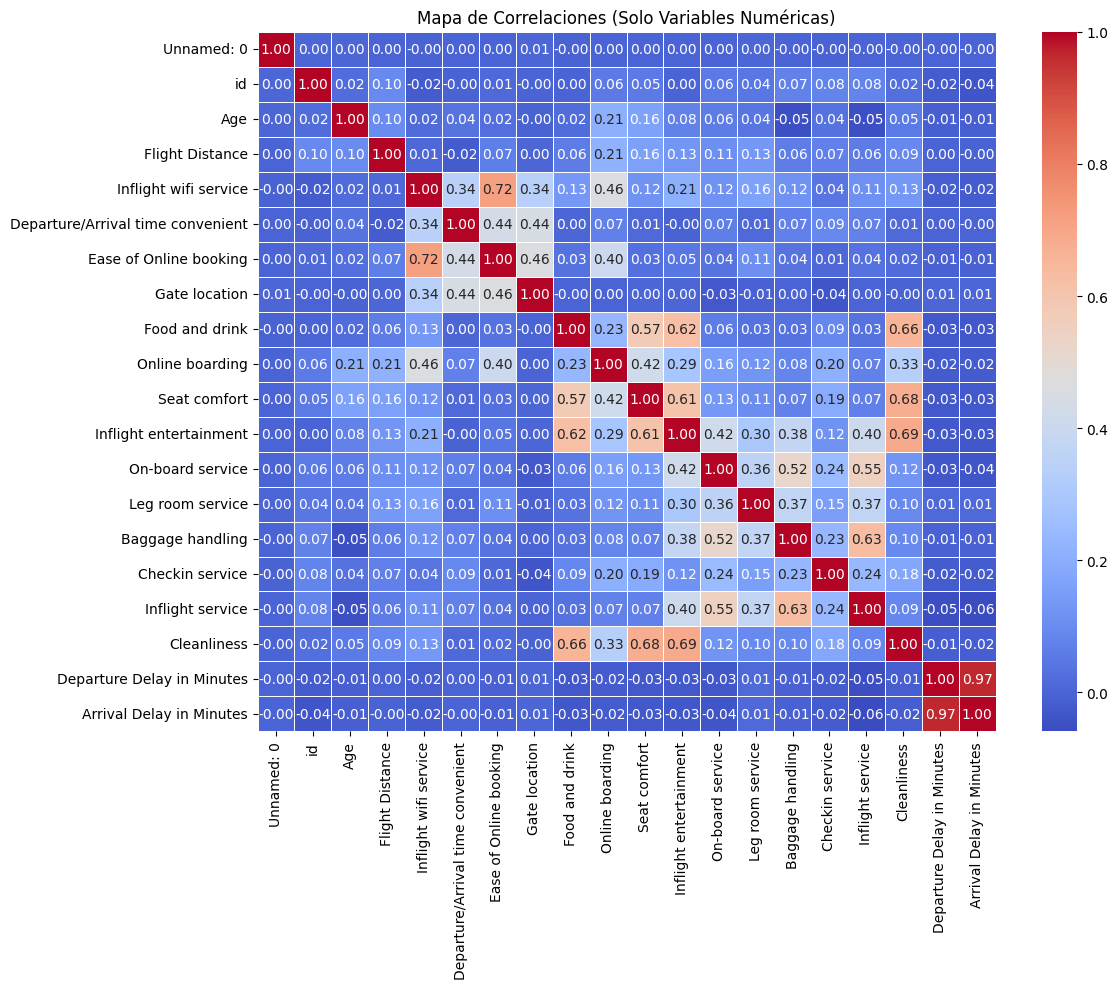

In [15]:
import sklearn as sk
from sklearn.preprocessing import LabelEncoder

numeric_columns = df_airlines.select_dtypes(include=['int64', 'float64'])
correlation_matrix_numeric = numeric_columns.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlaciones (Solo Variables Numéricas)')
plt.tight_layout()
plt.show()

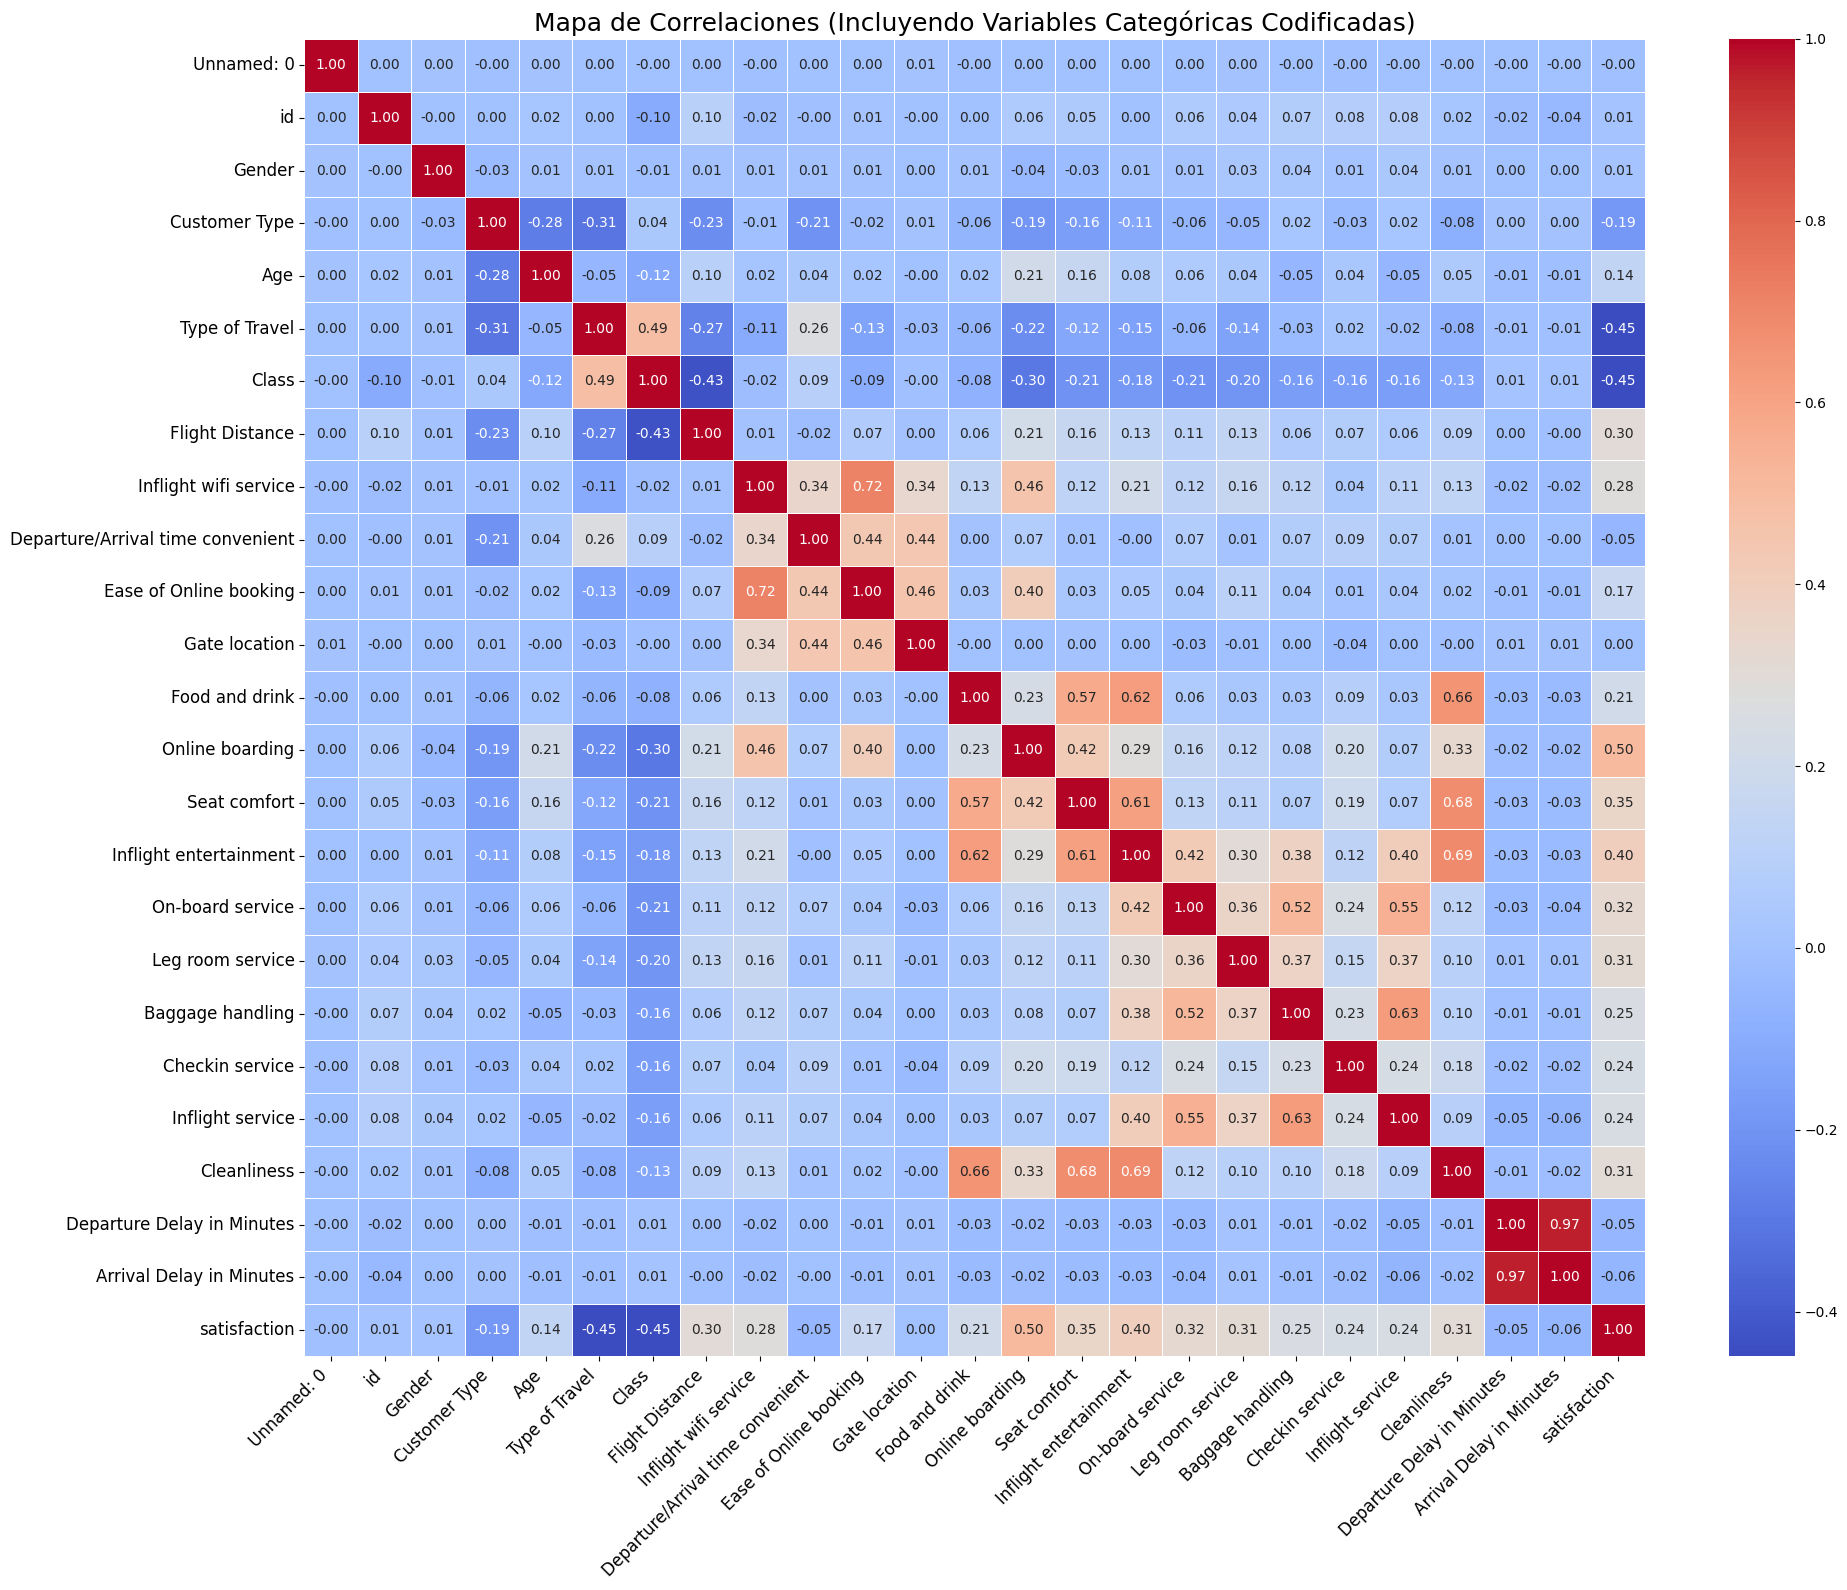

In [17]:
# Codificación de variables categóricas y matriz de correlación completa
from sklearn.preprocessing import LabelEncoder

df_correlation = df_airlines.copy()
label_encoder = LabelEncoder()

# Codificar columnas categóricas
for col in df_correlation.select_dtypes(include=['object']).columns:
    df_correlation[col] = label_encoder.fit_transform(df_correlation[col].astype(str))

# Matriz de correlación completa
correlation_matrix_complete = df_correlation.corr()

plt.figure(figsize=(20, 16))  # Aumenta el tamaño de la figura
sns.heatmap(
    correlation_matrix_complete, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5, 
    annot_kws={"size": 10}  # Ajusta el tamaño del texto de las anotaciones
)
plt.title('Mapa de Correlaciones (Incluyendo Variables Categóricas Codificadas)', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotación y tamaño de las etiquetas del eje X
plt.yticks(fontsize=12)  # Tamaño de las etiquetas del eje Y
plt.tight_layout()
plt.show()

Variables con correlación positiva significativa:
Online boarding: Correlación de aproximadamente 0.50. Es la variable más correlacionada positivamente con satisfaction.
Inflight entertainment: Correlación de aproximadamente 0.40.
Seat comfort: Correlación de aproximadamente 0.35.
Ease of Online booking: Correlación de aproximadamente 0.28.
Cleanliness: Correlación de aproximadamente 0.31.

Variables con correlación negativa significativa:
Class: Correlación de aproximadamente -0.45. Esto indica que ciertas clases (económica, por ejemplo) están asociadas con menor satisfacción.
Type of Travel: Correlación de aproximadamente -0.44. Esto podría indicar que el tipo de viaje (negocios o personal) influye en la satisfacción.

Departure Delay in Minutes y Arrival Delay in Minutes no son muy relevantes porque según la información del dataset se trata de viajeros recurrentes, entonces están acostumbrados a las tardanzas normales en los viajes.

In [50]:
print(df_airlines['Cleanliness'].unique())

[5 1 2 3 4 0]


Satisfaction: ['neutral or dissatisfied' 'satisfied']
Class: ['Eco Plus' 'Business' 'Eco']
Type of Travel: ['Personal Travel' 'Business travel']
Online boarding, Inflight entertainment, Seat comfort, Ease of Online booking y Cleanliness: [3 5 2 1 4 0] / nivel de satisfacción en la encuesta

In [51]:
# Contar la cantidad de registros por categoría
print(df_airlines['Type of Travel'].value_counts())

Type of Travel
Business travel    71655
Personal Travel    32249
Name: count, dtype: int64


satisfaction:
0    58879   No
1    45025   Sí

Class:
'Eco Plus': 1,
'Business': 2,
'Eco' : 3

Type of Travel:
'Business travel': 0,
'Personal Travel': 1


In [ ]:
# Seleccionar solo las columnas numéricas
numeric_columns = df_airlines.select_dtypes(include=['int64', 'float64'])

# Calculamos la correlación de 'satisfaction' con las demás variables
correlation_with_satisfaction = numeric_columns.corr()['satisfaction'].sort_values(ascending=False)
print(correlation_with_satisfaction)

satisfaction                         1.000000
Online boarding                      0.503557
Inflight entertainment               0.398059
Seat comfort                         0.349459
On-board service                     0.322383
Leg room service                     0.313131
Cleanliness                          0.305198
Flight Distance                      0.298780
Inflight wifi service                0.284245
Baggage handling                     0.247749
Inflight service                     0.244741
Checkin service                      0.236174
Food and drink                       0.209936
Ease of Online booking               0.171705
Age                                  0.137167
id                                   0.013734
Gate location                        0.000682
Unnamed: 0                          -0.004731
Departure Delay in Minutes          -0.050494
Departure/Arrival time convenient   -0.051601
Arrival Delay in Minutes            -0.057582
Class                             

Para probar diferentes modelos, vamos a estandarizar las variables numéricas ya que algunos modelos son sensibles a las escalas de las variables y otros no.

In [63]:
from sklearn.preprocessing import StandardScaler
numeric_columns = df_airlines.select_dtypes(include=['int64', 'float64'])
columns_to_scale = numeric_columns.columns.tolist()

scaler = StandardScaler()

# Aplicar el escalado solo a las columnas seleccionadas
df_airlines[columns_to_scale] = scaler.fit_transform(df_airlines[columns_to_scale])

# Verificar el resultado
print(df_airlines[columns_to_scale].head())

   Unnamed: 0        id       Age  Flight Distance  Inflight wifi service  Departure/Arrival time convenient  Ease of Online booking  Gate location  Food and drink  Online boarding  Seat comfort  Inflight entertainment  On-board service  Leg room service  Baggage handling  Checkin service  Inflight service  Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes
0   -1.732034  0.140077 -1.745279        -0.731539               0.203579                           0.616172                0.173776      -1.547323        1.352264        -0.185532      1.183099                1.231704          0.479403          -0.26684          0.311769         0.549799          1.156436     1.305870                    0.266393                  0.072905
1   -1.732001 -1.598276 -0.951360        -0.957184               0.203579                          -0.695245                0.173776       0.018094       -1.656326        -0.185532     -1.849315               -1.769081         -1.849161           1.2

La variable objetivo muy probablemente sera satisfaction ya que queremos predecir si el cliente está satisfecho o no según los datos que tenemos, entonces es un dato etiquetado, aprendizaje supervisado.

In [ ]:
# Ensure df_airlines is defined by executing the cell where it is created (CELL INDEX: 4)
categoric_columns = df_airlines.select_dtypes(include=['object'])
print(categoric_columns.columns.tolist())

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']


In [14]:
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

### Usamos el nuevo CSV para probar los modelos.

In [18]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   Gender                             103904 non-null  int64  
 2   Customer Type                      103904 non-null  int64  
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  int64  
 5   Class                              103904 non-null  int64  
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     1039

### Separamos losa datos de entrenamiento y prueba.

In [20]:
X = df_model.drop(["satisfaction"], axis=1) 
y = df_model["satisfaction"]  # Variable objetivo

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Probamos con algunos modelos:

In [22]:
models = {
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=1500,
        learning_rate=0.02,
        max_depth=3,
        min_samples_split=5,
        min_samples_leaf=5,
        subsample=0.8,
        max_features='sqrt',
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42
    )
}

results = []



In [ ]:
for name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Hacer predicciones en entrenamiento y prueba
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcular métricas en entrenamiento
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)

    # Calcular métricas en prueba
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)

    # Calcular AUC-ROC en prueba (si el modelo tiene predict_proba)
    if hasattr(model, "predict_proba"):  ## Su función es devolver la probabilidad de que cada instancia de entrada pertenezca a cada una de las clases posibles, es necesario para usar ROC AUC
        y_test_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_proba)
    else:
        roc_auc = None

    # Detectar overfitting de forma sencilla (comparando F1-Score)
    overfitting = False
    if f1_test < f1_train - 0.05:  # Una diferencia del 5% en F1 podría indicar overfitting
        overfitting = True

    results.append({
        'Model': name,
        'Accuracy Train': round(accuracy_train, 2),
        'Precision Train': round(precision_train, 2),
        'Recall Train': round(recall_train, 2),
        'F1 Train': round(f1_train, 2),
        'Accuracy Test': round(accuracy_test, 2),
        'Precision Test': round(precision_test, 2),
        'Recall Test': round(recall_test, 2),
        'F1 Test': round(f1_test, 2),
        'ROC AUC': round(roc_auc, 2) if roc_auc is not None else "N/A",   ## sirve para evaluar y comparar la capacidad de un modelo de clasificación binaria para distinguir entre las dos clases (positiva y negativa)
        'Overfitting': overfitting
    })

# Mostrar resultados ordenados
results_df = pd.DataFrame(results).sort_values(by='F1 Test', ascending=False)
print("\n Comparación de modelos con detección de Overfitting:\n")
print(results_df)


 Comparación de modelos con detección de Overfitting:

               Model  Accuracy Train  Precision Train  Recall Train  F1 Train  \
1      Random Forest            0.99             0.99          0.98      0.99   
0  Gradient Boosting            0.94             0.94          0.92      0.93   

   Accuracy Test  Precision Test  Recall Test  F1 Test  ROC AUC  Overfitting  
1           0.95            0.96         0.93     0.95     0.99        False  
0           0.94            0.94         0.92     0.93     0.99        False  
